In [88]:
# conda environment tf-gpu

In [152]:
from sklearn.model_selection import train_test_split
from os import listdir
from os.path import isfile, join
from scipy.io import savemat, loadmat
from sklearn.metrics import confusion_matrix

# import mat73
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

import os
import re
import random
import einops
from scipy.io import loadmat
from pathlib import Path
from PIL import Image
# import PIL.Image as Image

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# the following import is required for matplotlib < 3.2:
from mpl_toolkits.mplot3d import Axes3D  # noqa
import matplotlib
# matplotlib.use('Agg') # use a non-interactive backend such as Agg (for PNGs), PDF, SVG or PS.

In [153]:
# using CNN with TensorFlow core
import tensorflow as tf
from tensorflow import keras
from keras import Model, layers, models
print("TensorFlow version:", tf.__version__)
# from tensorflow.keras import datasets, layers, models
# from tensorflow.keras.layers import Dense, Flatten, Conv2D
import matplotlib.pyplot as plt
import collections
# TensorFlow version: 2.13.0

TensorFlow version: 2.17.0


In [154]:
# tf.config.list_physical_devices('GPU')
from tensorflow.python.client import device_lib
def get_available_device():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

In [155]:
print(get_available_device())

['/device:CPU:0']


In [156]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


# Configure video data

In [157]:
path = '../image dataset/'
files = os.listdir(path)
sub_num = 5
files_head = [f for f in files if re.match(r'^sub' + str(sub_num) + '.*_1\.jpg$', f)]

In [158]:
def get_class(fname):
  return fname.split('_')[1]

In [159]:
def get_sub(fname):
  return fname.split('_')[0]

In [160]:
def integrate_video(fname, path):
    img = Image.open(path + fname).convert('CMYK')
    data = np.expand_dims(np.asarray(img), axis=0)
    for i in range(1, 7):
        fn = fname.replace('_1.jpg',f'_{i+1}.jpg')
        img_ = Image.open(path + fn).convert('CMYK')
        arr = np.expand_dims(np.asarray(img_), axis=0)
        data = np.concatenate((data, arr), axis=0)  # shape: (frame_num, width, height, channel)
    return data


In [161]:
def save_video(files, path):
    ds = []
    sub_dict = []
    class_dict = []
    for f in files:
        data = integrate_video(f, path)
        sub = get_sub(f)
        cls = get_class(f)
        ds.append(data)
        sub_dict.append(sub)
        class_dict.append(cls)

    return ds, sub_dict, class_dict

In [176]:
data, sub_dict, class_dict = save_video(files_head, path)

In [177]:
data[0].shape

(7, 369, 433, 4)

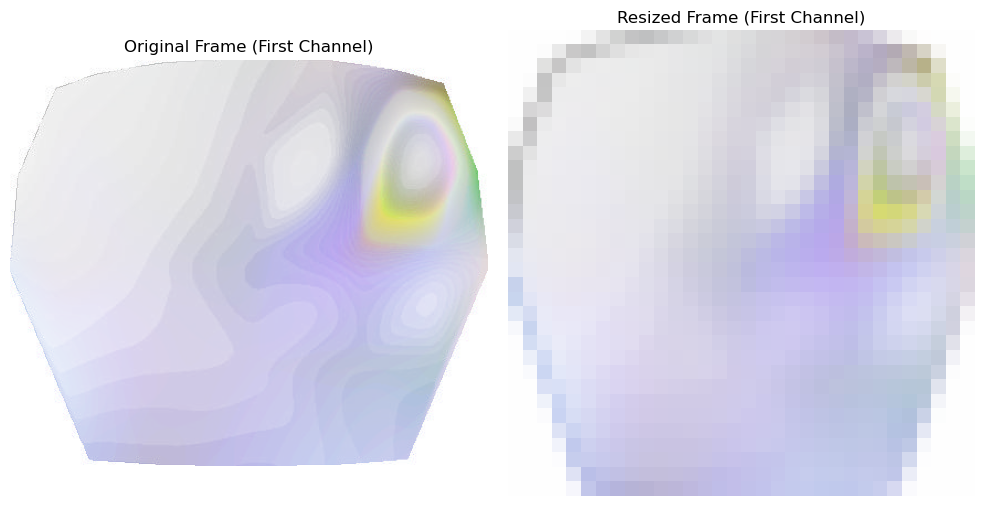

In [178]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

# Generate synthetic data as example (7 frames, 369x433 size, 4 channels)
original_data = data[0]

# Resize the data to (7, 32, 32, 4)
resized_data = np.zeros((7, 32, 32, 4))
for i in range(original_data.shape[0]):
    resized_data[i] = resize(original_data[i], (32, 32, 4), anti_aliasing=True)

# Plot the original and resized figure for the first frame
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the original frame (only first channel for visualization)
axes[0].imshow(original_data[4, :, :, :])
axes[0].set_title("Original Frame (First Channel)")
axes[0].axis('off')

# Display the resized frame (only first channel for visualization)
axes[1].imshow(resized_data[4, :, :, :])
axes[1].set_title("Resized Frame (First Channel)")
axes[1].axis('off')

plt.tight_layout()
plt.show()

def resize_image_size(data, target_size=(7, 32, 32, 4)):
    resized_data = []
    for one_video in data:
        resized_one_video = np.zeros(target_size)
        for i in range (one_video.shape[0]):
            resized_one_video[i] = resize(one_video[i], (target_size[1], target_size[2], target_size[3]), anti_aliasing=True)
        resized_data.append(resized_one_video)
    
    return resized_data

data = resize_image_size(data)


In [179]:
data[260].shape

(7, 32, 32, 4)

Load image: read as video frames (Tensorflow tutorial)

In [180]:
def get_files_per_class(files):
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

In [181]:
files_for_class = get_files_per_class(files)
classes = list(files_for_class.keys())

In [182]:
print('Num classes:', len(classes))
print('Num videos for class[0]:', len(files_for_class[classes[0]]))

Num classes: 6
Num videos for class[0]: 2205


In [183]:
def select_subset_of_classes(files_for_class, classes, files_per_class):
  """ 
    Use for 3-class/in-subclass comparison
  """
  files_subset = dict()

  for class_name in classes:
    class_files = files_for_class[class_name]
    files_subset[class_name] = class_files[:files_per_class]

  return files_subset

In [184]:
NUM_CLASSES = 2
FILES_PER_CLASS = 90   # 270 trials for each sub, 45 trials for each class per sub, 315 trials for each class in general

In [185]:
files_subset = select_subset_of_classes(files_for_class, classes[:NUM_CLASSES], FILES_PER_CLASS)
list(files_subset.keys())

['back', 'down']

In [108]:
# load data depends on subject and class

In [186]:
def get_files_per_sub_per_class(files):
  files_for_sub_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    sub_num = get_sub(fname)
    files_for_sub_for_class[(sub_num, class_name)].append(fname)
  return files_for_sub_for_class

In [187]:
files_for_sub_for_class = get_files_per_sub_per_class(files)
classes_2stage = list(files_for_sub_for_class.keys())

In [188]:
print('Num classes:', len(classes_2stage))
print('Num videos for class[0]:', len(files_for_sub_for_class[classes_2stage[0]]))

Num classes: 42
Num videos for class[0]: 315


select random train/test dataset

In [189]:
trial_dict = {'front':0, 'back':1, 'left':2, 'right':3, 'up':4, 'down':5}
label = [trial_dict[x] for x in class_dict]

In [190]:
x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.33, random_state=42)

In [191]:
print(x_train[0].shape)
print(len(x_train))
print(len(y_train))

(7, 32, 32, 4)
180
180


In [192]:
x_train = [tf.convert_to_tensor(item) for item in x_train]
x_test = [tf.convert_to_tensor(item) for item in x_test]
y_train = [tf.convert_to_tensor(item) for item in y_train]
y_test = [tf.convert_to_tensor(item) for item in y_test]

In [193]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [194]:
batch_size = 8
train_ds = train_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

In [195]:
test_batches = tf.data.experimental.cardinality(test_ds) # return the num of test batches
val_ds = test_ds.take(test_batches//3)
test_ds = test_ds.skip(test_batches//3)

## RCNN Model

In [197]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_cnn(input_shape, img_size, n_colors):
    """
    Builds a VGG-style CNN based on configuration D.
    """
    model = models.Sequential()
    model.add(layers.Conv2D(img_size, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.Conv2D(img_size, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(img_size, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(img_size, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(img_size*2, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(img_size*2, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(img_size*4, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    return model

def build_mixed_lstm_1dconv(input_shape, n_timewin, n_classes, img_size, n_colors):
    """
    Builds the mixed LSTM/1D-Conv network.
    """
    # Input for each time window (frame)
    cnn_inputs = [layers.Input(shape=input_shape) for _ in range(n_timewin)]
    
    # Shared CNN
    cnn = build_cnn(input_shape, img_size, n_colors)
    cnn_outputs = [cnn(inp) for inp in cnn_inputs]
    
    # Reshape the sequence
    reshaped = layers.Concatenate(axis=1)(cnn_outputs)
    reshaped = layers.Reshape((n_timewin, -1))(reshaped)
    
    # 1D Convolution for short-term temporal patterns
    conv1d_out = layers.Conv1D(64, 3, activation='relu')(reshaped)
    conv1d_out = layers.Flatten()(conv1d_out)
    
    # LSTM for long-term temporal dependencies
    lstm_out = layers.LSTM(128)(reshaped)
    
    # Merge 1D-Conv and LSTM outputs
    merged = layers.Concatenate()([conv1d_out, lstm_out])
    
    # Fully connected layers
    dense = layers.Dropout(0.5)(merged)
    dense = layers.Dense(512, activation='relu')(dense)
    dense = layers.Dropout(0.5)(dense)
    output = layers.Dense(n_classes, activation='softmax')(dense)
    
    # Model
    model = models.Model(inputs=cnn_inputs, outputs=output)
    return model

# Example usage
img_size = 32
n_colors = 4
input_shape = (img_size, img_size, n_colors)  # Example for 32x32 RGB images
n_timewin = 7
n_classes = 6

model = build_mixed_lstm_1dconv(input_shape, n_timewin, n_classes, img_size=img_size, n_colors=n_colors)
model.summary()


Model: "functional_218"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_216     │ (None, 32, 32, 4) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_217     │ (None, 32, 32, 4) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_218     │ (None, 32, 32, 4) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_219     │ (None, 32, 32, 4) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_220     │ (None, 32, 32, 4) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_221     │ (None, 32, 32, 4) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_222     │ (None, 32, 32, 4) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_49       │ (None, 2048)      │    158,208 │ input_layer_216[… │
│ (Sequential)        │                   │            │ input_layer_217[… │
│                     │                   │            │ input_layer_218[… │
│                     │                   │            │ input_layer_219[… │
│                     │                   │            │ input_layer_220[… │
│                     │                   │            │ input_layer_221[… │
│                     │                   │            │ input_layer_222[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_34      │ (None, 14336)     │          0 │ sequential_49[0]… │
│ (Concatenate)       │                   │            │ sequential_49[1]… │
│                     │                   │            │ sequential_49[2]… │
│                     │                   │            │ sequential_49[3]… │
│                     │                   │            │ sequential_49[4]… │
│                     │                   │            │ sequential_49[5]… │
│                     │                   │            │ sequential_49[6]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_15          │ (None, 7, 2048)   │          0 │ concatenate_34[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_22 (Conv1D)  │ (None, 5, 64)     │    393,280 │ reshape_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_78          │ (None, 320)       │          0 │ conv1d_22[0][0]   │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_22 (LSTM)      │ (None, 128)       │  1,114,624 │ reshape_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_35      │ (None, 448)       │          0 │ flatten_78[0][0], │
│ (Concatenate)       │                   │            │ lstm_22[0][0]   

 Total params: 1,899,078 (7.24 MB)

 Trainable params: 1,899,078 (7.24 MB)

 Non-trainable params: 0 (0.00 B)

# CNN Model

In [198]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.001), 
              metrics = ['accuracy'])

In [199]:
# checkpoint_path = "./sub5_training_stride1_1/cp.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint_path = "./sub5_training_stride1_1/cp.weights.h5"  # Change the file extension
checkpoint_dir = os.path.dirname(checkpoint_path)

In [200]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True, # save the entire model or weights only
                                                 verbose=1,
                                                 monitor='val_accuracy',
                                                 mode='max',  # max for acc, min for loss
                                                 save_best_only=True)

In [201]:
# print('hi')
history = model.fit(x = train_ds,
                    epochs = 60,
                    validation_data = val_ds,
                    callbacks=[cp_callback])

Epoch 1/60


ValueError: Layer "functional_218" expects 7 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'data:0' shape=(None, 7, 32, 32, 4) dtype=float64>]

if the training is interrupted

In [375]:
# # if the training is interrupted
# model.load_weights('./sub1_training_stride1_2/cp.ckpt')
# # model.load_weights(checkpoint_path)
# history = model.fit(x = train_ds,
#                     epochs = 30, 
#                     validation_data = val_ds,
#                     callbacks=[cp_callback])

In [376]:
# stride1
# sub1
# train acc: 65.56%; val acc: 31.25%; test acc: 27.59%   # sub1 train0
# train acc: 57.22%; val acc：34.375%； test acc: 22.41%   # sub1 train1
# train acc: 78.33%; val acc: 31.25%; test acc: 24.14%   # sub1 train2
# train acc: 50.56%; val acc: 28.125%; test acc: 29.31% # sub1 train3

# sub2
# train acc: 72.78%; val acc: 34.375%; test acc: 44.828% # sub2 train0
# train acc: 69.44%; val acc: 37.50%; test acc: 37.93% # sub2 train1
# train acc: 71.67%; val acc: 43.75%; test acc: 41.38% # sub2 train2
# train acc: 91.67%; val acc: 50.00%; test acc: 39.66% # sub2 train3 (additional training from train2 model)
# train acc: 73.33%; val acc: 37.50%; test acc: 48.28% # sub2 train4 (additional training from train0 model)

# sub3
# train acc: 41.11%; val acc: 34.375%; test acc: 24.14% # sub3 train0

# sub5
# train acc: 73.89%; val acc: 34.375%; test acc: 25.86% # sub5 train0

# sub7
# train acc: 66.11%; val acc: 31.25%; test acc: 25.86% # sub7 train0

In [377]:
model.load_weights('./sub5_training_stride1_1/cp.ckpt')
model.evaluate(val_ds, return_dict=True)

4/4 [==============================] - 1s 257ms/step - loss: 2.1572 - accuracy: 0.3438


{'loss': 2.157195806503296, 'accuracy': 0.34375}

In [384]:
model.load_weights('./sub5_training_stride1_1/cp.ckpt')
model.evaluate(test_ds, return_dict=True)

8/8 [==============================] - 3s 302ms/step - loss: 2.2734 - accuracy: 0.2586


{'loss': 2.273442268371582, 'accuracy': 0.2586206793785095}

### THE END

In [379]:
checkpoint_path = "./sub5_training_stride1_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [380]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True, # save the entire model or weights only
                                                 verbose=1,
                                                 monitor='val_accuracy',
                                                 mode='max',  # max for acc, min for loss
                                                 save_best_only=True)

In [381]:
model.load_weights('./sub3_training_stride1_1/cp.ckpt')
history = model.fit(x = train_ds,
                    epochs = 30, 
                    validation_data = val_ds,
                    callbacks=[cp_callback])

Epoch 1/30
23/23 [==============================] - 15s 634ms/step - loss: 2.8557 - accuracy: 0.1111 - val_loss: 2.6596 - val_accuracy: 0.1250

Epoch 00001: val_accuracy improved from -inf to 0.12500, saving model to ./sub5_training_stride1_1\cp.ckpt
Epoch 2/30
23/23 [==============================] - 15s 634ms/step - loss: 1.9630 - accuracy: 0.1444 - val_loss: 2.1048 - val_accuracy: 0.1250

Epoch 00002: val_accuracy did not improve from 0.12500
Epoch 3/30
23/23 [==============================] - 15s 633ms/step - loss: 1.8376 - accuracy: 0.1278 - val_loss: 2.0220 - val_accuracy: 0.1875

Epoch 00003: val_accuracy improved from 0.12500 to 0.18750, saving model to ./sub5_training_stride1_1\cp.ckpt
Epoch 4/30
23/23 [==============================] - 15s 636ms/step - loss: 1.7965 - accuracy: 0.1556 - val_loss: 2.0016 - val_accuracy: 0.1875

Epoch 00004: val_accuracy did not improve from 0.18750
Epoch 5/30
23/23 [==============================] - 15s 633ms/step - loss: 1.7545 - accuracy: 0.1

In [382]:
model.load_weights('./sub3_training_stride1_2/cp.ckpt')
model.evaluate(val_ds, return_dict=True)

4/4 [==============================] - 1s 255ms/step - loss: 2.5982 - accuracy: 0.1250


{'loss': 2.5981950759887695, 'accuracy': 0.125}

In [383]:
model.load_weights('./sub3_training_stride1_2/cp.ckpt')
model.evaluate(test_ds, return_dict=True)

8/8 [==============================] - 2s 234ms/step - loss: 2.4174 - accuracy: 0.1207


{'loss': 2.417375087738037, 'accuracy': 0.12068965286016464}

In [523]:
model.save_weights('./sub5_training_1.h5')

Text(0.5, 1.0, 'Confusion Matrix for Subject 2 on Test Dataset')

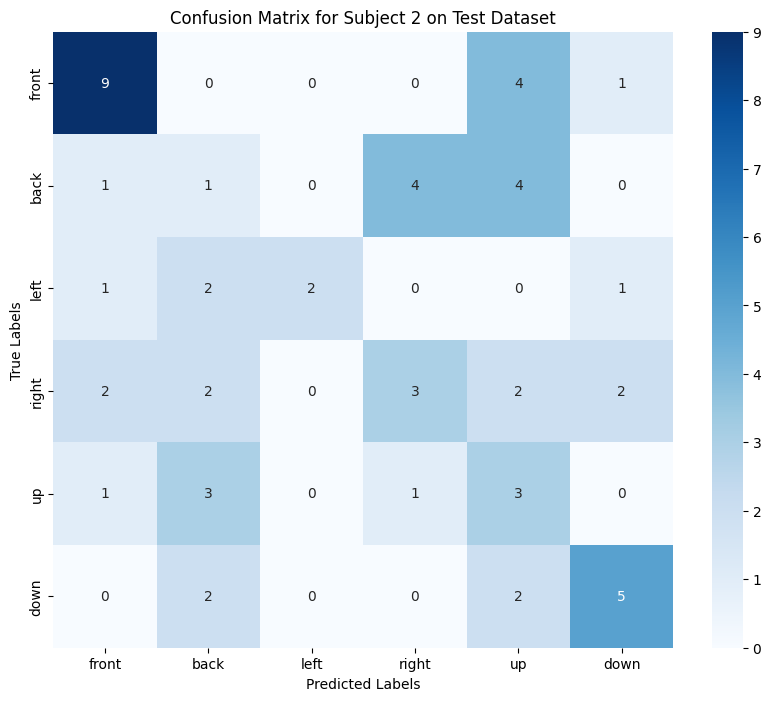

In [51]:
y_pred = []
y_true = []

for x, y in test_ds:
    y_pred_data = model.predict(x)
    y_pred.extend(tf.argmax(y_pred_data, axis=1).numpy())
    y_true.extend(y.numpy())

conf_mat = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5], ['front', 'back', 'left', 'right', 'up', 'down'])
plt.ylabel('True Labels')
plt.yticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5], ['front', 'back', 'left', 'right', 'up', 'down'])
plt.title(f'Confusion Matrix for Subject {sub_num} on Test Dataset')
# plt.savefig(f'./illustration/Confusion Matrix for Subject {sub_num} on Test Dataset.png')

In [369]:
model.evaluate(val_ds, return_dict=True)

4/4 [==============================] - 2s 398ms/step - loss: 1.9265 - accuracy: 0.3438


{'loss': 1.9264551401138306, 'accuracy': 0.34375}

Text(0.5, 1.0, 'Confusion Matrix for Subject 2 on Validation Dataset')

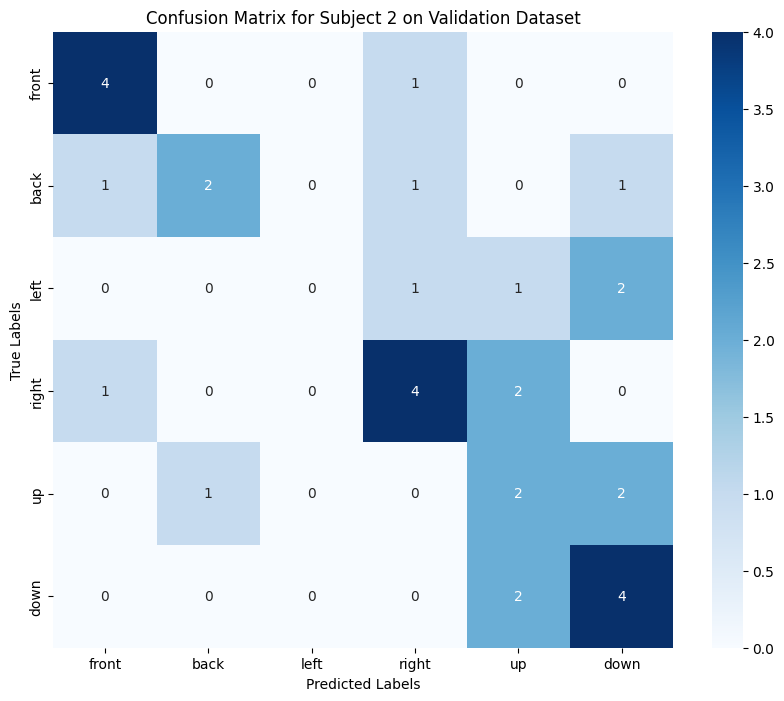

In [52]:
y_pred = []
y_true = []

for x, y in val_ds:
    y_pred_data = model.predict(x)
    y_pred.extend(tf.argmax(y_pred_data, axis=1).numpy())
    y_true.extend(y.numpy())

conf_mat = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5], ['front', 'back', 'left', 'right', 'up', 'down'])
plt.ylabel('True Labels')
plt.yticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5], ['front', 'back', 'left', 'right', 'up', 'down'])
plt.title(f'Confusion Matrix for Subject {sub_num} on Validation Dataset')
# plt.savefig(f'./illustration/Confusion Matrix for Subject {sub_num} on Validation Dataset.png')

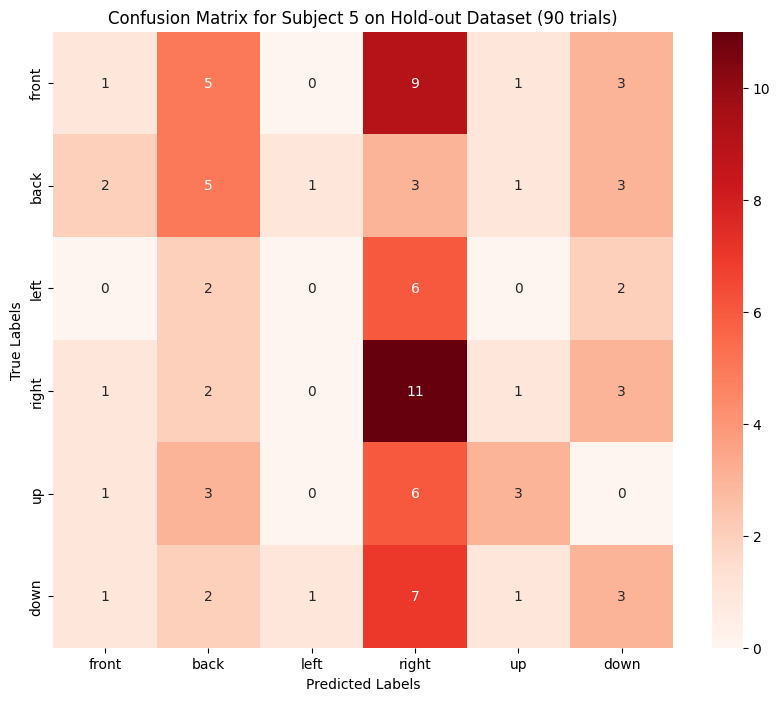

In [371]:
y_pred = []
y_true = []

for x, y in test_ds:
    y_pred_data = model.predict(x)
    y_pred.extend(tf.argmax(y_pred_data, axis=1).numpy())
    y_true.extend(y.numpy())

for x, y in val_ds:
    y_pred_data_val = model.predict(x)
    y_pred.extend(tf.argmax(y_pred_data_val, axis=1).numpy())
    y_true.extend(y.numpy())

conf_mat = confusion_matrix(y_true, y_pred)

# conf_mat = multilabel_confusion_matrix(y_true, y_pred) # what?
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Labels')
plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5], ['front', 'back', 'left', 'right', 'up', 'down'])
plt.ylabel('True Labels')
plt.yticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5], ['front', 'back', 'left', 'right', 'up', 'down'])
plt.title(f'Confusion Matrix for Subject {sub_num} on Hold-out Dataset (90 trials)')
plt.savefig(f'./illustration/Confusion Matrix for Subject {sub_num} on Hold-out Dataset.png')

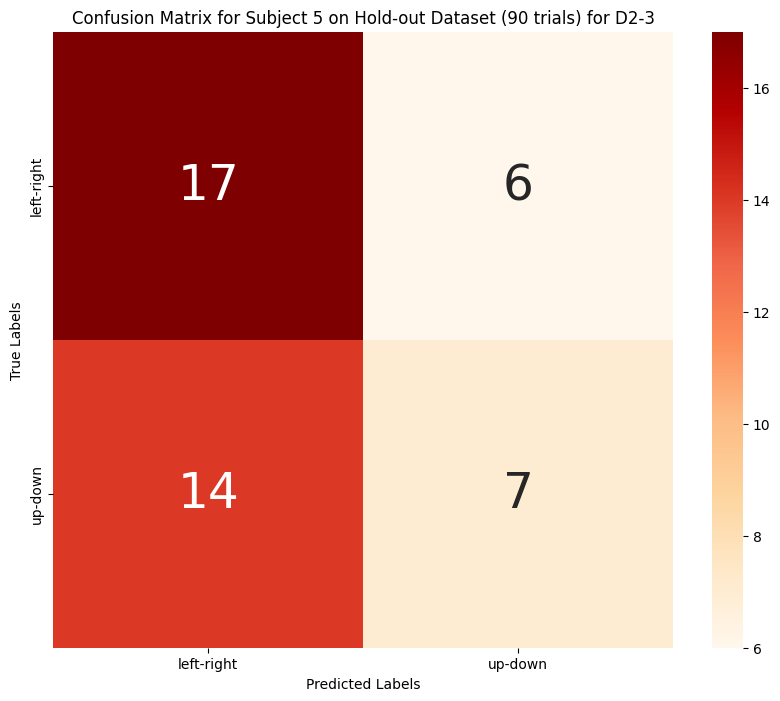

In [374]:
y_pred = []
y_true = []

for x, y in test_ds:
    y_pred_data = model.predict(x)
    y_pred.extend(tf.argmax(y_pred_data, axis=1).numpy())
    y_true.extend(y.numpy())

for x, y in val_ds:
    y_pred_data_val = model.predict(x)
    y_pred.extend(tf.argmax(y_pred_data_val, axis=1).numpy())
    y_true.extend(y.numpy())

conf_mat = confusion_matrix(y_true, y_pred)
new_mat = np.zeros((2,2))
# D13
# new_mat[0, 0] = np.sum(conf_mat[0:2, 0:2])
# new_mat[0, 1] = np.sum(conf_mat[0:2, 2:4])
# new_mat[1, 1] = np.sum(conf_mat[4:6, 4:6])
# new_mat[1, 0] = np.sum(conf_mat[4:6, 0:2])
# D12
# new_mat[0, 0] = np.sum(conf_mat[0:2, 0:2])
# new_mat[0, 1] = np.sum(conf_mat[0:2, 2:4])
# new_mat[1, 1] = np.sum(conf_mat[2:4, 2:4])
# new_mat[1, 0] = np.sum(conf_mat[2:4, 0:2])
# D23
new_mat[0, 0] = np.sum(conf_mat[2:4, 2:4])
new_mat[0, 1] = np.sum(conf_mat[2:4, 4:6])
new_mat[1, 1] = np.sum(conf_mat[4:6, 4:6])
new_mat[1, 0] = np.sum(conf_mat[4:6, 2:4])

# conf_mat = multilabel_confusion_matrix(y_true, y_pred) # what?
plt.figure(figsize=(10, 8))
sns.heatmap(new_mat.astype(int), annot=True, fmt='d', cmap='OrRd', annot_kws={'size':35})
plt.xlabel('Predicted Labels')
# # plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5], ['front', 'back', 'left', 'right', 'up', 'down'])
# plt.xticks([0.5, 1.5], ['front-back', 'up-down']) # D13
# plt.xticks([0.5, 1.5], ['front-back', 'left-right']) # D12
plt.xticks([0.5, 1.5], ['left-right', 'up-down']) # D23
plt.ylabel('True Labels')
# # plt.yticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5], ['front', 'back', 'left', 'right', 'up', 'down'])
# plt.yticks([0.5, 1.5], ['front-back', 'up-down']) # D13
# plt.yticks([0.5, 1.5], ['front-back', 'left-right']) # D12
plt.yticks([0.5, 1.5], ['left-right', 'up-down']) # D23
plt.title(f'Confusion Matrix for Subject {sub_num} on Hold-out Dataset (90 trials) for D2-3')
plt.savefig(f'./illustration/Confusion Matrix for Subject {sub_num} on Hold-out Dataset For D2-3.png')